In [3]:
%pip install pandas numpy scikit-learn matplotlib seaborn joblib

Import libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Load dataset

In [5]:
data = pd.read_csv('heart_failure_clinical_records.csv')
print("Dataset Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())
print("\nClass Balance:\n", data['DEATH_EVENT'].value_counts(normalize=True))
print("\nSummary Statistics:\n", data.describe())

Dataset Shape: (5000, 13)

Missing Values:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Class Balance:
 DEATH_EVENT
0    0.6864
1    0.3136
Name: proportion, dtype: float64

Summary Statistics:
                age      anaemia  creatinine_phosphokinase     diabetes  \
count  5000.000000  5000.000000               5000.000000  5000.000000   
mean     60.288736     0.474400                586.760600     0.439400   
std      11.697243     0.499394                976.733979     0.496364   
min      40.000000     0.000000                 23.000000     0.000000   
25%      50.000000     0.000000                121.000000     0.000000   
5

Step 2: Features and Target
We separate the dataset into features (`X`) and target (`y`). The target variable is `DEATH_EVENT`.

In [ ]:
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

Step 3: Nested Cross-Validation We perform nested cross-validation to tune hyperparameters using `GridSearchCV` on the inner fold and evaluate the model on the outer fold. We use `f1_macro` as the scoring metric.

In [ ]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'max_depth': [3,4,5], 'min_samples_leaf': [5,10,20]}

outer_f1_scores = []
outer_roc_auc_scores = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1_macro'
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    outer_f1_scores.append(f1_score(y_test, y_pred))
    outer_roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))

print("\nNested CV F1-scores:", outer_f1_scores)
print("Mean Nested CV F1-score:", np.mean(outer_f1_scores))
print("Nested CV ROC-AUCs:", outer_roc_auc_scores)
print("Mean Nested CV ROC-AUC:", np.mean(outer_roc_auc_scores))

Step 4: Train-Test Split + train final model with best params

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

final_model = DecisionTreeClassifier(
    random_state=42, class_weight='balanced',
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
)

final_model.fit(X_train, y_train)

Step 5: Predictions and metrics

In [ ]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='f1_macro')
print("\n5-Fold CV F1-Scores:", cv_scores)
print("Mean CV F1-Score:", cv_scores.mean())

Step 6: Feature importance

In [ ]:
feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feat_df)

ROC curve + decision tree + confusion matrix

In [ ]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived','Died'], yticklabels=['Survived','Died'])
plt.title('Confusion Matrix')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'DT ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plot_tree(final_model, feature_names=X.columns, class_names=['Survived','Died'], filled=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

export pkl

Dataset Shape: (5000, 13)

Missing Values:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Class Balance:
 DEATH_EVENT
0    0.6864
1    0.3136
Name: proportion, dtype: float64

Summary Statistics:
                age      anaemia  creatinine_phosphokinase     diabetes  \
count  5000.000000  5000.000000               5000.000000  5000.000000   
mean     60.288736     0.474400                586.760600     0.439400   
std      11.697243     0.499394                976.733979     0.496364   
min      40.000000     0.000000                 23.000000     0.000000   
25%      50.000000     0.000000                121.000000     0.000000   
5

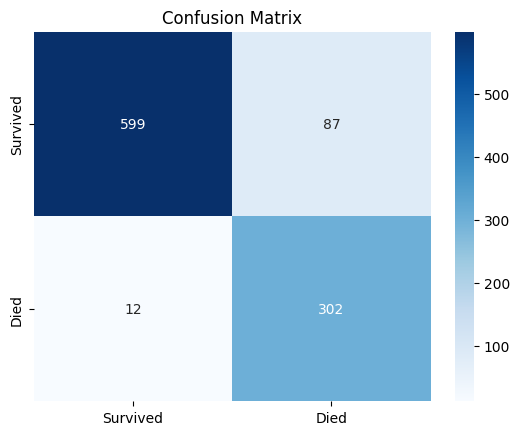

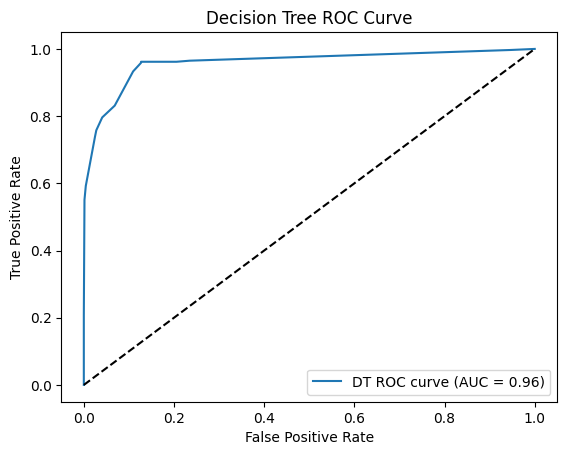

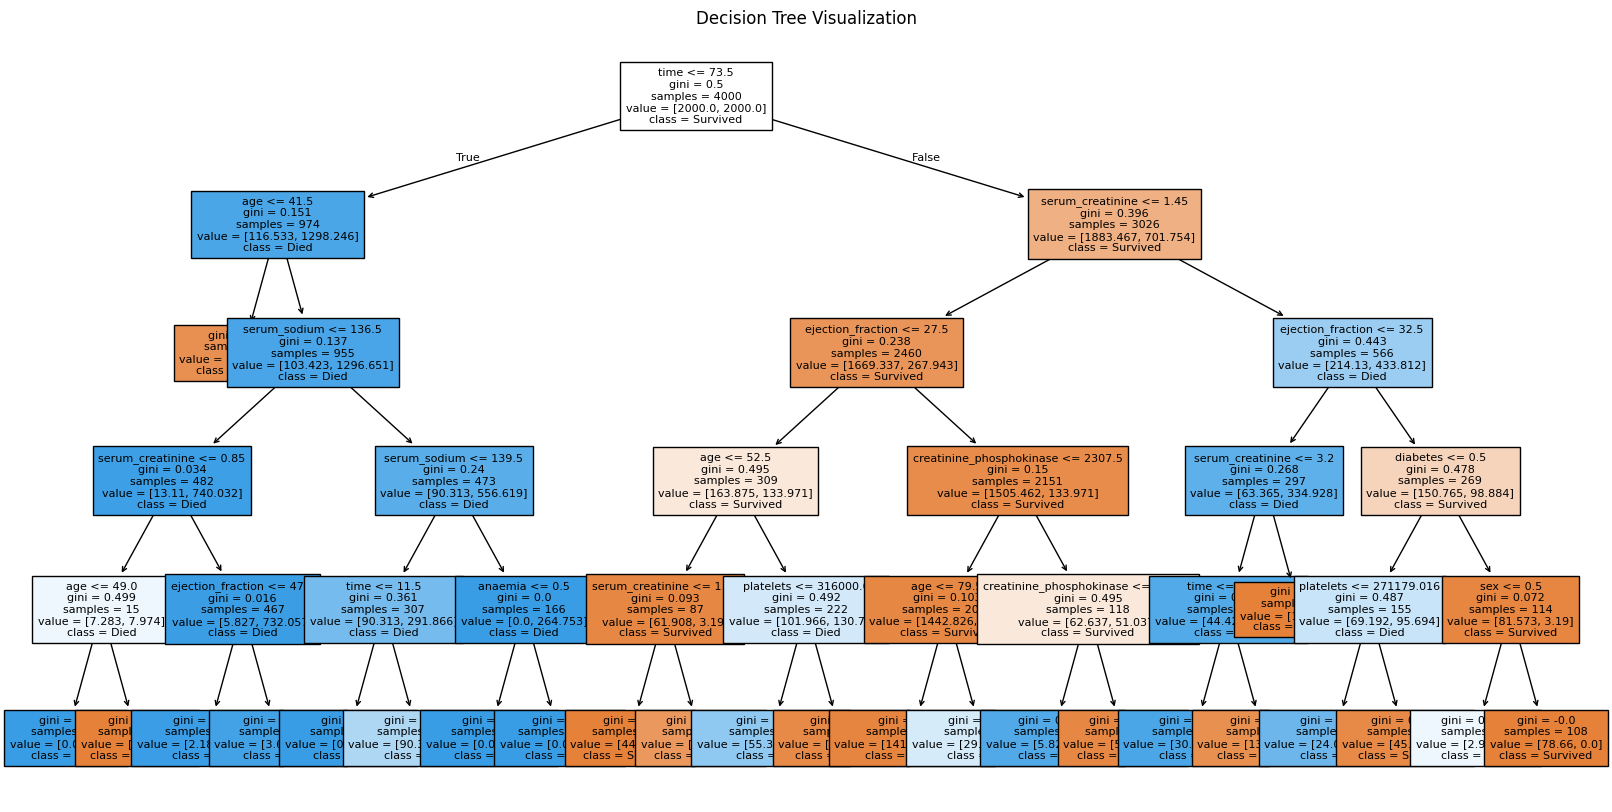

['decision_tree_model.pkl']

In [2]:
joblib.dump(final_model, 'decision_tree_model.pkl')